In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from joblib import dump, load
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### **Loading the dataset**

In [2]:
data = pd.read_csv('coffee_shop_revenue.csv')
data.head()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
0,152,6.74,14,4,106.62,97,1547.81
1,485,4.50,12,8,57.83,744,2084.68
2,398,9.09,6,6,91.76,636,3118.39
3,320,8.48,17,4,462.63,770,2912.20
4,156,7.44,17,2,412.52,232,1663.42


In [3]:
data.shape

(2000, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Number_of_Customers_Per_Day  2000 non-null   int64  
 1   Average_Order_Value          2000 non-null   float64
 2   Operating_Hours_Per_Day      2000 non-null   int64  
 3   Number_of_Employees          2000 non-null   int64  
 4   Marketing_Spend_Per_Day      2000 non-null   float64
 5   Location_Foot_Traffic        2000 non-null   int64  
 6   Daily_Revenue                2000 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 109.5 KB


In [5]:
data.isnull().sum()

Number_of_Customers_Per_Day    0
Average_Order_Value            0
Operating_Hours_Per_Day        0
Number_of_Employees            0
Marketing_Spend_Per_Day        0
Location_Foot_Traffic          0
Daily_Revenue                  0
dtype: int64

In [6]:
for column in data.columns:
    if data[column].dtype == 'object':  
        print(f"Value counts for {column}:")
        print(data[column].value_counts())
        print("_" * 30) 
        print("")

### **Splitting the dataset**

In [7]:
X = data.drop(columns='price')
y = data['price']

In [8]:
X.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [9]:
y.head()

0    13300000
1    12250000
2    12250000
3    12215000
4    11410000
Name: price, dtype: int64

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=2)

In [11]:
print(f'xtrain shape:{xtrain.shape}\nytrain shape: {ytrain.shape}\nxtest shape: {xtest.shape}\nytest shape: {ytest.shape}')

xtrain shape:(436, 12)
ytrain shape: (436,)
xtest shape: (109, 12)
ytest shape: (109,)


### **Minimally pre-processing the splits**
- As there are categorical columns they need to be encodedto be used for model training.

In [12]:
xtrain.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
412,2610,3,1,2,yes,no,yes,no,no,0,yes,unfurnished
284,7770,2,1,1,yes,no,no,no,no,1,no,furnished
504,3185,2,1,1,yes,no,no,no,yes,0,no,unfurnished
209,6720,3,1,1,yes,no,no,no,no,0,no,unfurnished
269,3900,3,1,2,yes,no,no,no,no,0,no,unfurnished


In [13]:
xtest.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
333,3000,3,1,2,yes,no,no,no,no,0,no,semi-furnished
84,3760,3,1,2,yes,no,no,yes,no,2,no,semi-furnished
439,3930,2,1,1,no,no,no,no,no,0,no,unfurnished
396,3640,2,1,1,yes,no,no,no,no,1,no,semi-furnished
161,6100,3,1,3,yes,yes,no,no,yes,0,yes,semi-furnished


In [14]:
xtrain['mainroad'] = xtrain['mainroad'].map({'yes': 1, 'no': 0})
xtest['mainroad'] = xtest['mainroad'].map({'yes': 1, 'no': 0})

xtrain['guestroom'] = xtrain['guestroom'].map({'yes': 1, 'no': 0})
xtest['guestroom'] = xtest['guestroom'].map({'yes': 1, 'no': 0})

xtrain['basement'] = xtrain['basement'].map({'yes': 1, 'no': 0})
xtest['basement'] = xtest['basement'].map({'yes': 1, 'no': 0})

xtrain['hotwaterheating'] = xtrain['hotwaterheating'].map({'yes': 1, 'no': 0})
xtest['hotwaterheating'] = xtest['hotwaterheating'].map({'yes': 1, 'no': 0})

xtrain['airconditioning'] = xtrain['airconditioning'].map({'yes': 1, 'no': 0})
xtest['airconditioning'] = xtest['airconditioning'].map({'yes': 1, 'no': 0})

xtrain['prefarea'] = xtrain['prefarea'].map({'yes': 1, 'no': 0})
xtest['prefarea'] = xtest['prefarea'].map({'yes': 1, 'no': 0})

In [15]:
encoded_feature = pd.get_dummies(xtrain['furnishingstatus'], drop_first=True).astype(int)
xtrain = pd.concat([xtrain, encoded_feature], axis=1)
xtrain

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
412,2610,3,1,2,1,0,1,0,0,0,1,unfurnished,0,1
284,7770,2,1,1,1,0,0,0,0,1,0,furnished,0,0
504,3185,2,1,1,1,0,0,0,1,0,0,unfurnished,0,1
209,6720,3,1,1,1,0,0,0,0,0,0,unfurnished,0,1
269,3900,3,1,2,1,0,0,0,0,0,0,unfurnished,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,7000,3,1,1,1,0,0,0,0,3,0,furnished,0,0
534,3000,4,1,2,1,0,0,0,0,0,0,unfurnished,0,1
493,3960,3,1,1,1,0,0,0,0,0,0,furnished,0,0
527,1836,2,1,1,0,0,1,0,0,0,0,semi-furnished,1,0


In [16]:
encoded_feature1 = pd.get_dummies(xtest['furnishingstatus'], drop_first=True).astype(int)
xtest = pd.concat([xtest, encoded_feature1], axis=1)
xtest

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
333,3000,3,1,2,1,0,0,0,0,0,0,semi-furnished,1,0
84,3760,3,1,2,1,0,0,1,0,2,0,semi-furnished,1,0
439,3930,2,1,1,0,0,0,0,0,0,0,unfurnished,0,1
396,3640,2,1,1,1,0,0,0,0,1,0,semi-furnished,1,0
161,6100,3,1,3,1,1,0,0,1,0,1,semi-furnished,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,6600,3,2,1,1,0,1,0,1,0,1,unfurnished,0,1
344,3850,2,1,1,1,0,0,0,0,0,0,semi-furnished,1,0
176,8520,3,1,1,1,0,0,0,1,2,0,furnished,0,0
244,5320,3,1,2,1,1,1,0,0,0,1,semi-furnished,1,0


In [17]:
xtrain.drop(columns='furnishingstatus', inplace=True)
xtest.drop(columns='furnishingstatus', inplace=True)

In [18]:
xtrain.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
412,2610,3,1,2,1,0,1,0,0,0,1,0,1
284,7770,2,1,1,1,0,0,0,0,1,0,0,0
504,3185,2,1,1,1,0,0,0,1,0,0,0,1
209,6720,3,1,1,1,0,0,0,0,0,0,0,1
269,3900,3,1,2,1,0,0,0,0,0,0,0,1


In [19]:
xtest.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
333,3000,3,1,2,1,0,0,0,0,0,0,1,0
84,3760,3,1,2,1,0,0,1,0,2,0,1,0
439,3930,2,1,1,0,0,0,0,0,0,0,0,1
396,3640,2,1,1,1,0,0,0,0,1,0,1,0
161,6100,3,1,3,1,1,0,0,1,0,1,1,0


### **Saving the minimally pre-processed train and test splits**

In [20]:
xtrain.to_csv('xtrain_min_processed.csv')
ytrain.to_csv('ytrain_min_processed.csv')
xtest.to_csv('xtest_min_processed.csv')
ytest.to_csv('ytest_min_processed.csv')

### **Model training to get baseline metrics**

In [21]:
models_dict = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "SVR": SVR(),
    "XGBoostRegressor": XGBRegressor(),
    "KNN": KNeighborsRegressor()
}

baseline_results = {}

def train_model(models_dict, xtrain, ytrain):
    cv_type = KFold(n_splits=5, shuffle=True, random_state=3)
    
    for model_name, model in models_dict.items():
        print(f'Training model: {model_name}')
        r2_scores = cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='r2')
        mae_scores = -cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='neg_mean_absolute_error')  # Convert to positive
        rmse_scores = -cross_val_score(model, xtrain, ytrain, cv=cv_type, scoring='neg_root_mean_squared_error')  # Convert to positive

        r2_mean = np.mean(r2_scores)
        mae_mean = np.mean(mae_scores)
        rmse_mean = np.mean(rmse_scores)

        baseline_results[model_name] = {
            "R2_score": round(r2_mean, 4),
            "MAE": round(mae_mean, 4),
            "RMSE": round(rmse_mean, 4)
        }

        print(f"R2 Score: {r2_mean:.4f}")
        print(f"MAE: {mae_mean:.4f}")
        print(f"RMSE: {rmse_mean:.4f}")
        print('-' * 35)
        print(' ')

    with open("baseline_metrics.json", "w") as f:
        json.dump(baseline_results, f, indent=4)
    
    print("Baseline metrics saved to 'baseline_metrics.json'")

In [22]:
train_model(models_dict, xtrain, ytrain)

Training model: LinearRegression
R2 Score: 0.6533
MAE: 789498.4796
RMSE: 1082794.0492
-----------------------------------
 
Training model: Ridge
R2 Score: 0.6539
MAE: 787704.7118
RMSE: 1081799.3525
-----------------------------------
 
Training model: Lasso
R2 Score: 0.6533
MAE: 789497.6533
RMSE: 1082793.7315
-----------------------------------
 
Training model: ElasticNet
R2 Score: 0.5733
MAE: 872641.0988
RMSE: 1205053.5380
-----------------------------------
 
Training model: DecisionTreeRegressor
R2 Score: 0.3462
MAE: 1039431.1740
RMSE: 1434581.4724
-----------------------------------
 
Training model: RandomForestRegressor
R2 Score: 0.6148
MAE: 811191.1436
RMSE: 1142206.9302
-----------------------------------
 
Training model: SVR
R2 Score: -0.0699
MAE: 1404775.3712
RMSE: 1908761.9012
-----------------------------------
 
Training model: XGBoostRegressor
R2 Score: 0.5591
MAE: 891369.4664
RMSE: 1212371.0362
-----------------------------------
 
Training model: KNN
R2 Score: 0.3340

### **Baseline Model Analysis**
- Linear models (**Ridge**, **LinearRegression**, **Lasso**) consistently provided the best metrics, suggesting they are well-suited for baseline predictions.
- Tree-based models and advanced techniques like **ElasticNet**, **XGBoost** and **RandomForest** showed promise but will require further tuning.
- Models like **SVR** and **KNN** demonstrated poor fit, indicating misalignment with the dataset's characteristics.


### **Next Steps**
Currently, linear models—**Ridge**, **Lasso**, and **Linear Regression**—have delivered the best baseline metrics among all models. For now, I will focus on improving these models and also hyperparameter tune them. If their performance significantly improves after tuning, they will remain the primary models. If not, I will shift focus to enhancing the remaining models for better results.

- ### **Working on improving performance of linear regression model**

In [23]:
xtrain.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
412,2610,3,1,2,1,0,1,0,0,0,1,0,1
284,7770,2,1,1,1,0,0,0,0,1,0,0,0
504,3185,2,1,1,1,0,0,0,1,0,0,0,1
209,6720,3,1,1,1,0,0,0,0,0,0,0,1
269,3900,3,1,2,1,0,0,0,0,0,0,0,1


In [24]:
xtest.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
333,3000,3,1,2,1,0,0,0,0,0,0,1,0
84,3760,3,1,2,1,0,0,1,0,2,0,1,0
439,3930,2,1,1,0,0,0,0,0,0,0,0,1
396,3640,2,1,1,1,0,0,0,0,1,0,1,0
161,6100,3,1,3,1,1,0,0,1,0,1,1,0


- ### Using just standard scaling

In [25]:
std_scaler = StandardScaler()
scaled_xtrain = pd.DataFrame(std_scaler.fit_transform(xtrain), columns=xtrain.columns)
scaled_xtest = pd.DataFrame(std_scaler.transform(xtest), columns=xtest.columns)

In [26]:
scaled_xtrain.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,-1.176872,0.032015,-0.583762,0.200759,0.410975,-0.463125,1.333068,-0.201427,-0.676900,-0.786806,1.786703,-0.842499,1.431416
1,1.239913,-1.363844,-0.583762,-0.936004,0.410975,-0.463125,-0.750149,-0.201427,-0.676900,0.400209,-0.559690,-0.842499,-0.698609
2,-0.907560,-1.363844,-0.583762,-0.936004,0.410975,-0.463125,-0.750149,-0.201427,1.477322,-0.786806,-0.559690,-0.842499,1.431416
3,0.748125,0.032015,-0.583762,-0.936004,0.410975,-0.463125,-0.750149,-0.201427,-0.676900,-0.786806,-0.559690,-0.842499,1.431416
4,-0.572676,0.032015,-0.583762,0.200759,0.410975,-0.463125,-0.750149,-0.201427,-0.676900,-0.786806,-0.559690,-0.842499,1.431416


In [27]:
scaled_xtest.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,-0.994208,0.032015,-0.583762,0.200759,0.410975,-0.463125,-0.750149,-0.201427,-0.676900,-0.786806,-0.559690,1.186946,-0.698609
1,-0.638248,0.032015,-0.583762,0.200759,0.410975,-0.463125,-0.750149,4.964580,-0.676900,1.587225,-0.559690,1.186946,-0.698609
2,-0.558625,-1.363844,-0.583762,-0.936004,-2.433235,-0.463125,-0.750149,-0.201427,-0.676900,-0.786806,-0.559690,-0.842499,1.431416
3,-0.694452,-1.363844,-0.583762,-0.936004,0.410975,-0.463125,-0.750149,-0.201427,-0.676900,0.400209,-0.559690,1.186946,-0.698609
4,0.457736,0.032015,-0.583762,1.337521,0.410975,2.159245,-0.750149,-0.201427,1.477322,-0.786806,1.786703,1.186946,-0.698609


In [28]:
lin_reg = LinearRegression()
lin_reg.fit(scaled_xtrain, ytrain)

LinearRegression()

In [29]:
cv_type1 = KFold(n_splits=5, shuffle=True, random_state=4)
r2 = cross_val_score(lin_reg, scaled_xtrain, ytrain, cv=cv_type1, scoring='r2')
mae = -cross_val_score(lin_reg, scaled_xtrain, ytrain, cv=cv_type1, scoring='neg_mean_absolute_error')
rmse = -cross_val_score(lin_reg, scaled_xtrain, ytrain, cv=cv_type1, scoring='neg_root_mean_squared_error')

r2_mean = r2.mean()
mae_mean = mae.mean()
rmse_mean = rmse.mean()

print(f"Mean R²: {r2_mean:.4f}")
print(f"Mean MAE: {mae_mean:.4f}")
print(f"Mean RMSE: {rmse_mean:.4f}")

Mean R²: 0.6504
Mean MAE: 785594.7587
Mean RMSE: 1078125.9931


In [30]:
ypred_linreg = lin_reg.predict(scaled_xtest)

In [31]:
def get_metrics(ytest, ypred):
    r2 = r2_score(ytest, ypred)
    mae = mean_absolute_error(ytest, ypred)
    rmse = np.sqrt(mean_squared_error(ytest, ypred))
    print(f"R2 score: {r2}")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")

In [32]:
get_metrics(ytest, ypred_linreg)

R2 score: 0.6298518608872242
MAE: 873450.0161445062
RMSE: 1146160.3774614423


- Compared to the baseline metrics of linear regression model the above metrics r2 score has been reduced, mae and rmse has been increased 

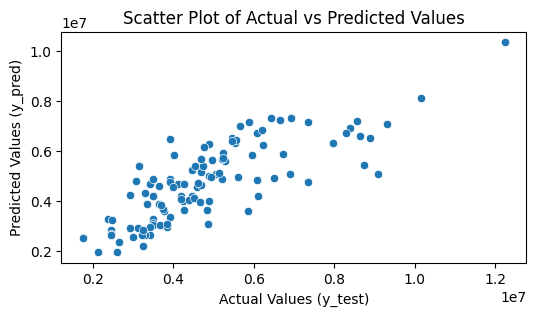

In [33]:
plt.figure(figsize=(6, 3))
sns.scatterplot(x=ytest, y=ypred_linreg)
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of Actual vs Predicted Values")
plt.show()

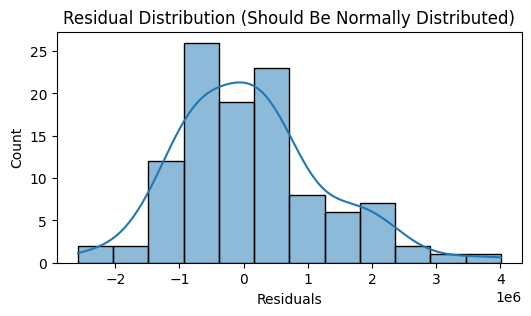

In [34]:
residuals = ytest - ypred_linreg
plt.figure(figsize=(6, 3))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution (Should Be Normally Distributed)")
plt.show()

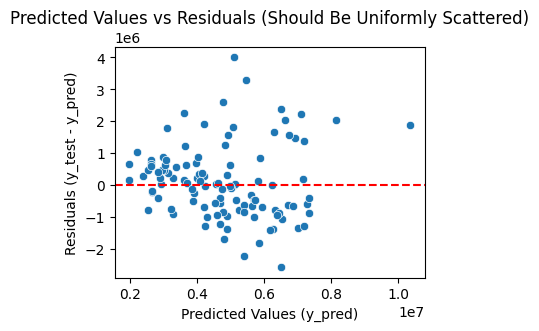

In [35]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x=ypred_linreg, y=residuals)
plt.axhline(y=0, color='r', linestyle='--') 
plt.xlabel("Predicted Values (y_pred)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Predicted Values vs Residuals (Should Be Uniformly Scattered)")
plt.show()

- ### Using degree2 polynomial features and standard scaling

In [36]:
xtrain.head(2)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
412,2610,3,1,2,1,0,1,0,0,0,1,0,1
284,7770,2,1,1,1,0,0,0,0,1,0,0,0


In [37]:
xtest.head(2)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
333,3000,3,1,2,1,0,0,0,0,0,0,1,0
84,3760,3,1,2,1,0,0,1,0,2,0,1,0


In [38]:
poly = PolynomialFeatures(degree=2)
xtrain_poly = poly.fit_transform(xtrain)
xtest_poly = poly.transform(xtest)

feature_names = poly.get_feature_names_out(xtrain.columns)
xtrain_poly = pd.DataFrame(xtrain_poly, columns=feature_names)
xtest_poly = pd.DataFrame(xtest_poly, columns=feature_names)

std_scaler = StandardScaler()
xtrain_poly_scaled = pd.DataFrame(std_scaler.fit_transform(xtrain_poly), columns=feature_names)
xtest_poly_scaled = pd.DataFrame(std_scaler.transform(xtest_poly), columns=feature_names)

In [39]:
pd.set_option('display.max_columns', None)

In [40]:
xtrain_poly_scaled.head(2)

,1,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,area^2,area bedrooms,area bathrooms,area stories,area mainroad,area guestroom,area basement,area hotwaterheating,area airconditioning,area parking,area prefarea,area semi-furnished,area unfurnished,bedrooms^2,bedrooms bathrooms,bedrooms stories,bedrooms mainroad,bedrooms guestroom,bedrooms basement,bedrooms hotwaterheating,bedrooms airconditioning,bedrooms parking,bedrooms prefarea,bedrooms semi-furnished,bedrooms unfurnished,bathrooms^2,bathrooms stories,bathrooms mainroad,bathrooms guestroom,bathrooms basement,bathrooms hotwaterheating,bathrooms airconditioning,bathrooms parking,bathrooms prefarea,bathrooms semi-furnished,bathrooms unfurnished,stories^2,stories mainroad,stories guestroom,stories basement,stories hotwaterheating,stories airconditioning,stories parking,stories prefarea,stories semi-furnished,stories unfurnished,mainroad^2,mainroad guestroom,mainroad basement,mainroad hotwaterheating,mainroad airconditioning,mainroad parking,mainroad prefarea,mainroad semi-furnished,mainroad unfurnished,guestroom^2,guestroom basement,guestroom hotwaterheating,guestroom airconditioning,guestroom parking,guestroom prefarea,guestroom semi-furnished,guestroom unfurnished,basement^2,basement hotwaterheating,basement airconditioning,basement parking,basement prefarea,basement semi-furnished,basement unfurnished,hotwaterheating^2,hotwaterheating airconditioning,hotwaterheating parking,hotwaterheating prefarea,hotwaterheating semi-furnished,hotwaterheating unfurnished,airconditioning^2,airconditioning parking,airconditioning prefarea,airconditioning semi-furnished,airconditioning unfurnished,parking^2,parking prefarea,parking semi-furnished,parking unfurnished,prefarea^2,prefarea semi-furnished,prefarea unfurnished,semi-furnished^2,semi-furnished unfurnished,unfurnished^2
0,0.0,-1.176872,0.032015,-0.583762,0.200759,0.410975,-0.463125,1.333068,-0.201427,-0.6769,-0.786806,1.786703,-0.842499,1.431416,-0.847457,-0.976415,-0.994707,-0.633334,-0.730518,-0.440688,0.241871,-0.178839,-0.623728,-0.682146,0.385326,-0.742135,0.464820,-0.083487,-0.449318,0.091659,0.376892,-0.451227,1.240352,-0.195505,-0.65978,-0.749792,1.687451,-0.809447,1.463612,-0.554029,-0.257251,-0.164593,-0.425073,0.690453,-0.185706,-0.618462,-0.706400,1.072883,-0.745212,0.991217,-0.023864,0.384869,-0.40466,1.641390,-0.188221,-0.583518,-0.656138,1.697995,-0.727255,1.490333,0.410975,-0.441045,1.493194,-0.175308,-0.633979,-0.740757,1.809561,-0.73528,1.66091,-0.463125,-0.395599,-0.067884,-0.304519,-0.302907,-0.266933,-0.286157,-0.201427,1.333068,-0.118125,-0.379943,-0.409907,2.552889,-0.44475,3.103892,-0.201427,-0.047946,-0.151637,-0.083237,-0.127738,-0.096225,-0.6769,-0.42284,-0.339248,-0.36799,-0.308994,-0.615157,-0.363078,-0.437579,-0.328047,1.786703,-0.317821,3.817254,-0.842499,0.0,1.431416
1,0.0,1.239913,-1.363844,-0.583762,-0.936004,0.410975,-0.463125,-0.750149,-0.201427,-0.6769,0.400209,-0.559690,-0.842499,-0.698609,1.044721,0.013977,0.246599,-0.255904,1.150482,-0.440688,-0.663911,-0.178839,-0.623728,0.616685,-0.512467,-0.742135,-0.637641,-1.193260,-0.923659,-1.075153,-0.440645,-0.451227,-0.723789,-0.195505,-0.65978,-0.028934,-0.548806,-0.809447,-0.665870,-0.554029,-0.776516,-0.164593,-0.425073,-0.671708,-0.185706,-0.618462,0.073323,-0.512802,-0.745212,-0.639616,-0.749771,-0.547369,-0.40466,-0.670875,-0.188221,-0.583518,-0.135052,-0.485857,-0.727255,-0.595655,0.410975,-0.441045,-0.669705,-0.175308,-0.633979,0.437966,-0.552620,-0.73528,-0.60208,-0.463125,-0.395599,-0.067884,-0.304519,-0.302907,-0.266933,-0.286157,-0.201427,-0.750149,-0.118125,-0.379943,-0.409907,-0.391713,-0.44475,-0.322176,-0.201427,-0.047946,-0.151637,-0.083237,-0.127738,-0.096225,-0.6769,-0.42284,-0.339248,-0.36799,-0.308994,-0.079811,-0.363078,-0.437579,-0.328047,-0.559690,-0.317821,-0.261968,-0.842499,0.0,-0.698609


In [41]:
xtest_poly_scaled.head(2)

,1,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,area^2,area bedrooms,area bathrooms,area stories,area mainroad,area guestroom,area basement,area hotwaterheating,area airconditioning,area parking,area prefarea,area semi-furnished,area unfurnished,bedrooms^2,bedrooms bathrooms,bedrooms stories,bedrooms mainroad,bedrooms guestroom,bedrooms basement,bedrooms hotwaterheating,bedrooms airconditioning,bedrooms parking,bedrooms prefarea,bedrooms semi-furnished,bedrooms unfurnished,bathrooms^2,bathrooms stories,bathrooms mainroad,bathrooms guestroom,bathrooms basement,bathrooms hotwaterheating,bathrooms airconditioning,bathrooms parking,bathrooms prefarea,bathrooms semi-furnished,bathrooms unfurnished,stories^2,stories mainroad,stories guestroom,stories basement,stories hotwaterheating,stories airconditioning,stories parking,stories prefarea,stories semi-furnished,stories unfurnished,mainroad^2,mainroad guestroom,mainroad basement,mainroad hotwaterheating,mainroad airconditioning,mainroad parking,mainroad prefarea,mainroad semi-furnished,mainroad unfurnished,guestroom^2,guestroom basement,guestroom hotwaterheating,guestroom airconditioning,guestroom parking,guestroom prefarea,guestroom semi-furnished,guestroom unfurnished,basement^2,basement hotwaterheating,basement airconditioning,basement parking,basement prefarea,basement semi-furnished,basement unfurnished,hotwaterheating^2,hotwaterheating airconditioning,hotwaterheating parking,hotwaterheating prefarea,hotwaterheating semi-furnished,hotwaterheating unfurnished,airconditioning^2,airconditioning parking,airconditioning prefarea,airconditioning semi-furnished,airconditioning unfurnished,parking^2,parking prefarea,parking semi-furnished,parking unfurnished,prefarea^2,prefarea semi-furnished,prefarea unfurnished,semi-furnished^2,semi-furnished unfurnished,unfurnished^2
0,0.0,-0.994208,0.032015,-0.583762,0.200759,0.410975,-0.463125,-0.750149,-0.201427,-0.6769,-0.786806,-0.55969,1.186946,-0.698609,-0.770164,-0.826122,-0.900887,-0.517885,-0.588349,-0.440688,-0.663911,-0.178839,-0.623728,-0.682146,-0.512467,0.300572,-0.637641,-0.083487,-0.449318,0.091659,0.376892,-0.451227,-0.723789,-0.195505,-0.65978,-0.749792,-0.548806,1.122591,-0.66587,-0.554029,-0.257251,-0.164593,-0.425073,-0.671708,-0.185706,-0.618462,-0.706400,-0.512802,0.60859,-0.639616,-0.023864,0.384869,-0.40466,-0.670875,-0.188221,-0.583518,-0.656138,-0.485857,1.230048,-0.595655,0.410975,-0.441045,-0.669705,-0.175308,-0.633979,-0.740757,-0.55262,1.360027,-0.60208,-0.463125,-0.395599,-0.067884,-0.304519,-0.302907,-0.266933,-0.286157,-0.201427,-0.750149,-0.118125,-0.379943,-0.409907,-0.391713,-0.44475,-0.322176,-0.201427,-0.047946,-0.151637,-0.083237,-0.127738,-0.096225,-0.6769,-0.42284,-0.339248,-0.36799,-0.308994,-0.615157,-0.363078,-0.437579,-0.328047,-0.55969,-0.317821,-0.261968,1.186946,0.0,-0.698609
1,0.0,-0.638248,0.032015,-0.583762,0.200759,0.410975,-0.463125,-0.750149,4.964580,-0.6769,1.587225,-0.55969,1.186946,-0.698609,-0.588664,-0.533244,-0.718059,-0.292907,-0.311303,-0.440688,-0.663911,3.293353,-0.623728,0.574895,-0.512467,0.564725,-0.637641,-0.083487,-0.449318,0.091659,0.376892,-0.451227,-0.723789,4.629421,-0.65978,1.412783,-0.548806,1.122591,-0.66587,-0.554029,-0.257251,-0.164593,-0.425073,-0.671708,3.053000,-0.618462,0.853045,-0.512802,0.60859,-0.639616,-0.023864,0.384869,-0.40466,-0.670875,4.785387,-0.583518,1.428205,-0.485857,1.230048,-0.595655,0.410975,-0.441045,-0.669705,5.704249,-0.633979,1.616689,-0.55262,1.360027,-0.60208,-0.463125,-0.395599,-0.067884,-0.304519,-0.302907,-0.266933,-0.286157,-0.201427,-0.750149,-0.118125,-0.379943,-0.409907,-0.391713,-0.44475,-0.322176,4.964580,-0.047946,9.293206,-0.083237,7.828519,-0.096225,-0.6769,-0.42284,-0.339248,-0.36799,-0.308994,1.526227,-0.363078,2.614975,-0.328047,-0.55969,-0.317821,-0.261968,1.186946,0.0,-0.698609


In [42]:
xtrain_poly_scaled.drop(columns=["1"], inplace=True)
xtest_poly_scaled.drop(columns=["1"], inplace=True)

In [43]:
xtrain_poly_scaled.head(2)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,area^2,area bedrooms,area bathrooms,area stories,area mainroad,area guestroom,area basement,area hotwaterheating,area airconditioning,area parking,area prefarea,area semi-furnished,area unfurnished,bedrooms^2,bedrooms bathrooms,bedrooms stories,bedrooms mainroad,bedrooms guestroom,bedrooms basement,bedrooms hotwaterheating,bedrooms airconditioning,bedrooms parking,bedrooms prefarea,bedrooms semi-furnished,bedrooms unfurnished,bathrooms^2,bathrooms stories,bathrooms mainroad,bathrooms guestroom,bathrooms basement,bathrooms hotwaterheating,bathrooms airconditioning,bathrooms parking,bathrooms prefarea,bathrooms semi-furnished,bathrooms unfurnished,stories^2,stories mainroad,stories guestroom,stories basement,stories hotwaterheating,stories airconditioning,stories parking,stories prefarea,stories semi-furnished,stories unfurnished,mainroad^2,mainroad guestroom,mainroad basement,mainroad hotwaterheating,mainroad airconditioning,mainroad parking,mainroad prefarea,mainroad semi-furnished,mainroad unfurnished,guestroom^2,guestroom basement,guestroom hotwaterheating,guestroom airconditioning,guestroom parking,guestroom prefarea,guestroom semi-furnished,guestroom unfurnished,basement^2,basement hotwaterheating,basement airconditioning,basement parking,basement prefarea,basement semi-furnished,basement unfurnished,hotwaterheating^2,hotwaterheating airconditioning,hotwaterheating parking,hotwaterheating prefarea,hotwaterheating semi-furnished,hotwaterheating unfurnished,airconditioning^2,airconditioning parking,airconditioning prefarea,airconditioning semi-furnished,airconditioning unfurnished,parking^2,parking prefarea,parking semi-furnished,parking unfurnished,prefarea^2,prefarea semi-furnished,prefarea unfurnished,semi-furnished^2,semi-furnished unfurnished,unfurnished^2
0,-1.176872,0.032015,-0.583762,0.200759,0.410975,-0.463125,1.333068,-0.201427,-0.6769,-0.786806,1.786703,-0.842499,1.431416,-0.847457,-0.976415,-0.994707,-0.633334,-0.730518,-0.440688,0.241871,-0.178839,-0.623728,-0.682146,0.385326,-0.742135,0.464820,-0.083487,-0.449318,0.091659,0.376892,-0.451227,1.240352,-0.195505,-0.65978,-0.749792,1.687451,-0.809447,1.463612,-0.554029,-0.257251,-0.164593,-0.425073,0.690453,-0.185706,-0.618462,-0.706400,1.072883,-0.745212,0.991217,-0.023864,0.384869,-0.40466,1.641390,-0.188221,-0.583518,-0.656138,1.697995,-0.727255,1.490333,0.410975,-0.441045,1.493194,-0.175308,-0.633979,-0.740757,1.809561,-0.73528,1.66091,-0.463125,-0.395599,-0.067884,-0.304519,-0.302907,-0.266933,-0.286157,-0.201427,1.333068,-0.118125,-0.379943,-0.409907,2.552889,-0.44475,3.103892,-0.201427,-0.047946,-0.151637,-0.083237,-0.127738,-0.096225,-0.6769,-0.42284,-0.339248,-0.36799,-0.308994,-0.615157,-0.363078,-0.437579,-0.328047,1.786703,-0.317821,3.817254,-0.842499,0.0,1.431416
1,1.239913,-1.363844,-0.583762,-0.936004,0.410975,-0.463125,-0.750149,-0.201427,-0.6769,0.400209,-0.559690,-0.842499,-0.698609,1.044721,0.013977,0.246599,-0.255904,1.150482,-0.440688,-0.663911,-0.178839,-0.623728,0.616685,-0.512467,-0.742135,-0.637641,-1.193260,-0.923659,-1.075153,-0.440645,-0.451227,-0.723789,-0.195505,-0.65978,-0.028934,-0.548806,-0.809447,-0.665870,-0.554029,-0.776516,-0.164593,-0.425073,-0.671708,-0.185706,-0.618462,0.073323,-0.512802,-0.745212,-0.639616,-0.749771,-0.547369,-0.40466,-0.670875,-0.188221,-0.583518,-0.135052,-0.485857,-0.727255,-0.595655,0.410975,-0.441045,-0.669705,-0.175308,-0.633979,0.437966,-0.552620,-0.73528,-0.60208,-0.463125,-0.395599,-0.067884,-0.304519,-0.302907,-0.266933,-0.286157,-0.201427,-0.750149,-0.118125,-0.379943,-0.409907,-0.391713,-0.44475,-0.322176,-0.201427,-0.047946,-0.151637,-0.083237,-0.127738,-0.096225,-0.6769,-0.42284,-0.339248,-0.36799,-0.308994,-0.079811,-0.363078,-0.437579,-0.328047,-0.559690,-0.317821,-0.261968,-0.842499,0.0,-0.698609


In [44]:
xtest_poly_scaled.head(2)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,area^2,area bedrooms,area bathrooms,area stories,area mainroad,area guestroom,area basement,area hotwaterheating,area airconditioning,area parking,area prefarea,area semi-furnished,area unfurnished,bedrooms^2,bedrooms bathrooms,bedrooms stories,bedrooms mainroad,bedrooms guestroom,bedrooms basement,bedrooms hotwaterheating,bedrooms airconditioning,bedrooms parking,bedrooms prefarea,bedrooms semi-furnished,bedrooms unfurnished,bathrooms^2,bathrooms stories,bathrooms mainroad,bathrooms guestroom,bathrooms basement,bathrooms hotwaterheating,bathrooms airconditioning,bathrooms parking,bathrooms prefarea,bathrooms semi-furnished,bathrooms unfurnished,stories^2,stories mainroad,stories guestroom,stories basement,stories hotwaterheating,stories airconditioning,stories parking,stories prefarea,stories semi-furnished,stories unfurnished,mainroad^2,mainroad guestroom,mainroad basement,mainroad hotwaterheating,mainroad airconditioning,mainroad parking,mainroad prefarea,mainroad semi-furnished,mainroad unfurnished,guestroom^2,guestroom basement,guestroom hotwaterheating,guestroom airconditioning,guestroom parking,guestroom prefarea,guestroom semi-furnished,guestroom unfurnished,basement^2,basement hotwaterheating,basement airconditioning,basement parking,basement prefarea,basement semi-furnished,basement unfurnished,hotwaterheating^2,hotwaterheating airconditioning,hotwaterheating parking,hotwaterheating prefarea,hotwaterheating semi-furnished,hotwaterheating unfurnished,airconditioning^2,airconditioning parking,airconditioning prefarea,airconditioning semi-furnished,airconditioning unfurnished,parking^2,parking prefarea,parking semi-furnished,parking unfurnished,prefarea^2,prefarea semi-furnished,prefarea unfurnished,semi-furnished^2,semi-furnished unfurnished,unfurnished^2
0,-0.994208,0.032015,-0.583762,0.200759,0.410975,-0.463125,-0.750149,-0.201427,-0.6769,-0.786806,-0.55969,1.186946,-0.698609,-0.770164,-0.826122,-0.900887,-0.517885,-0.588349,-0.440688,-0.663911,-0.178839,-0.623728,-0.682146,-0.512467,0.300572,-0.637641,-0.083487,-0.449318,0.091659,0.376892,-0.451227,-0.723789,-0.195505,-0.65978,-0.749792,-0.548806,1.122591,-0.66587,-0.554029,-0.257251,-0.164593,-0.425073,-0.671708,-0.185706,-0.618462,-0.706400,-0.512802,0.60859,-0.639616,-0.023864,0.384869,-0.40466,-0.670875,-0.188221,-0.583518,-0.656138,-0.485857,1.230048,-0.595655,0.410975,-0.441045,-0.669705,-0.175308,-0.633979,-0.740757,-0.55262,1.360027,-0.60208,-0.463125,-0.395599,-0.067884,-0.304519,-0.302907,-0.266933,-0.286157,-0.201427,-0.750149,-0.118125,-0.379943,-0.409907,-0.391713,-0.44475,-0.322176,-0.201427,-0.047946,-0.151637,-0.083237,-0.127738,-0.096225,-0.6769,-0.42284,-0.339248,-0.36799,-0.308994,-0.615157,-0.363078,-0.437579,-0.328047,-0.55969,-0.317821,-0.261968,1.186946,0.0,-0.698609
1,-0.638248,0.032015,-0.583762,0.200759,0.410975,-0.463125,-0.750149,4.964580,-0.6769,1.587225,-0.55969,1.186946,-0.698609,-0.588664,-0.533244,-0.718059,-0.292907,-0.311303,-0.440688,-0.663911,3.293353,-0.623728,0.574895,-0.512467,0.564725,-0.637641,-0.083487,-0.449318,0.091659,0.376892,-0.451227,-0.723789,4.629421,-0.65978,1.412783,-0.548806,1.122591,-0.66587,-0.554029,-0.257251,-0.164593,-0.425073,-0.671708,3.053000,-0.618462,0.853045,-0.512802,0.60859,-0.639616,-0.023864,0.384869,-0.40466,-0.670875,4.785387,-0.583518,1.428205,-0.485857,1.230048,-0.595655,0.410975,-0.441045,-0.669705,5.704249,-0.633979,1.616689,-0.55262,1.360027,-0.60208,-0.463125,-0.395599,-0.067884,-0.304519,-0.302907,-0.266933,-0.286157,-0.201427,-0.750149,-0.118125,-0.379943,-0.409907,-0.391713,-0.44475,-0.322176,4.964580,-0.047946,9.293206,-0.083237,7.828519,-0.096225,-0.6769,-0.42284,-0.339248,-0.36799,-0.308994,1.526227,-0.363078,2.614975,-0.328047,-0.55969,-0.317821,-0.261968,1.186946,0.0,-0.698609


In [46]:
lin_reg1 = LinearRegression()
lin_reg1.fit(xtrain_poly_scaled, ytrain)

LinearRegression()

In [47]:
cv_type1 = KFold(n_splits=5, shuffle=True, random_state=5)
r2 = cross_val_score(lin_reg, xtrain_poly_scaled, ytrain, cv=cv_type1, scoring='r2')
mae = -cross_val_score(lin_reg, xtrain_poly_scaled, ytrain, cv=cv_type1, scoring='neg_mean_absolute_error')
rmse = -cross_val_score(lin_reg, xtrain_poly_scaled, ytrain, cv=cv_type1, scoring='neg_root_mean_squared_error')

r2_mean = r2.mean()
mae_mean = mae.mean()
rmse_mean = rmse.mean()

print(f"Mean R²: {r2_mean:.4f}")
print(f"Mean MAE: {mae_mean:.4f}")
print(f"Mean RMSE: {rmse_mean:.4f}")

Mean R²: -112909889339331652354048.0000
Mean MAE: 62651560268313960.0000
Mean RMSE: 315196009654405952.0000


In [49]:
ypred_linreg1 = lin_reg1.predict(xtest_poly_scaled)

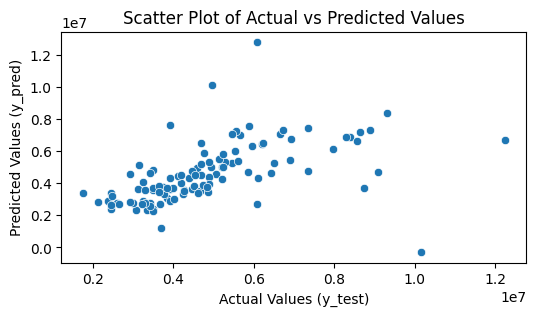

In [50]:
plt.figure(figsize=(6, 3))
sns.scatterplot(x=ytest, y=ypred_linreg1)
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Scatter Plot of Actual vs Predicted Values")
plt.show()

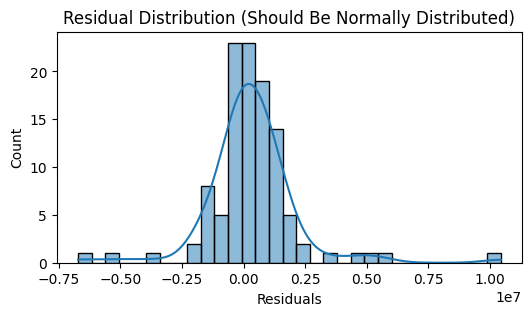

In [51]:
residuals = ytest - ypred_linreg1
plt.figure(figsize=(6, 3))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residual Distribution (Should Be Normally Distributed)")
plt.show()

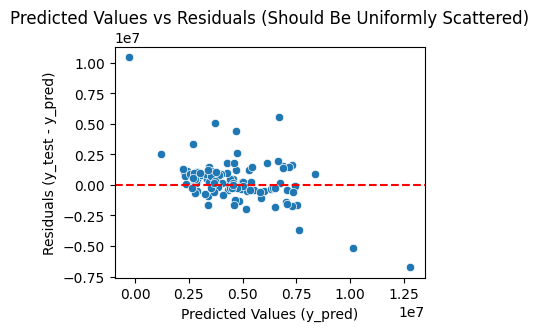

In [52]:
plt.figure(figsize=(4, 3))
sns.scatterplot(x=ypred_linreg1, y=residuals)
plt.axhline(y=0, color='r', linestyle='--') 
plt.xlabel("Predicted Values (y_pred)")
plt.ylabel("Residuals (y_test - y_pred)")
plt.title("Predicted Values vs Residuals (Should Be Uniformly Scattered)")
plt.show()

In [53]:
get_metrics(ytest, ypred_linreg1)

R2 score: 0.018748179610325155
MAE: 1128343.246275566
RMSE: 1866155.5616450626
